In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

sns.set_palette("husl")
sns.set_style("whitegrid")

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
#dataset = "initial"
dataset = "final2"
references_algorithms = ["Boost Kruskal", "Boost Prim"]

filenames = glob.glob(f"data/{dataset}/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [3]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]
for ref in references_algorithms:
    reference_times = df[(df.Algorithm == ref) & (df['Max threads'] == 1)][["Graph", "time"]].groupby('Graph').median()['time']
    df[f'{ref} speedup'] = df.apply(lambda x: reference_times[x.Graph] / x.time if x.Graph in reference_times.index else None , 1)
df['speedup'] = df.apply(lambda x: df[(df.Algorithm == x.Algorithm) & (df.Graph == x.Graph) & (df['Max threads'] == 1)].time.median() / x.time, 1)

In [4]:
s = df[["Algorithm", "Graph", "Max threads", "speedup", "time"]]\
    .groupby(("Graph", "Algorithm", "Max threads"))\
    .agg(["median", "std"])
s.time.to_csv(f"summaries/{dataset}/time_summary.csv")
s.time.to_latex(f"summaries/{dataset}/time_summary.tex")
s.speedup.to_csv(f"summaries/{dataset}/speedup_summary.csv")
s.speedup.to_latex(f"summaries/{dataset}/speedup_summary.tex")

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [5]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput,Boost Kruskal speedup,Boost Prim speedup,speedup
id,,,,,,,,,,,,
0,Boost MergeLocal,1000,Preferential attachment 100 edges per vertice,8,0,675860.308105,0,(Preferential attachment 100 edges per vertice...,0.000001,None,None,0.110336
0,Boost MergeLocal,1000,Preferential attachment 100 edges per vertice,8,1,670111.765015,1,(Preferential attachment 100 edges per vertice...,0.000001,None,None,0.111282
0,Boost BoruvkaThenMerge,1000,Preferential attachment 100 edges per vertice,12,0,941146.291443,0,(Preferential attachment 100 edges per vertice...,0.000001,None,None,0.079788
0,Boost BoruvkaThenMerge,1000,Preferential attachment 100 edges per vertice,12,1,962443.805542,0,(Preferential attachment 100 edges per vertice...,0.000001,None,None,0.078023
0,Boost MergeLocal,2000,Preferential attachment 20 edges per vertice,8,0,610221.837830,0,"(Preferential attachment 20 edges per vertice,...",0.000002,None,None,0.040368


In [6]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput,Boost Kruskal speedup,Boost Prim speedup,speedup
id,,,,,,,,,,,,
0,Boost MergeLocal,2000,Preferential attachment 20 edges per vertice,8,1,610713.876038,3,"(Preferential attachment 20 edges per vertice,...",0.000002,None,None,0.040336
0,Boost BoruvkaThenMerge,1000,Preferential attachment 100 edges per vertice,2,0,347335.724609,0,(Preferential attachment 100 edges per vertice...,0.000003,None,None,0.216195
0,Boost BoruvkaThenMerge,1000,Preferential attachment 100 edges per vertice,2,1,343427.991699,0,(Preferential attachment 100 edges per vertice...,0.000003,None,None,0.218655
0,Boost MergeLocal,2000,Preferential attachment 20 edges per vertice,10,0,917192.417786,0,"(Preferential attachment 20 edges per vertice,...",0.000001,None,None,0.026858
0,Boost MergeLocal,2000,Preferential attachment 20 edges per vertice,10,1,932980.495544,83,"(Preferential attachment 20 edges per vertice,...",0.000001,None,None,0.026403


In [7]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [8]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [9]:
summary

time                \
                                                       median          mean   
Algorithm               Max threads Graph nodes                               
Boost BoruvkaMixedMerge 1           1000         7.457251e+04  7.459239e+04   
                                    2000         2.455843e+04  2.464688e+04   
                        2           1000         3.462703e+05  3.458561e+05   
                                    2000         3.003182e+05  3.013555e+05   
                        4           1000         6.348599e+05  6.349496e+05   
                                    2000         5.994569e+05  6.000361e+05   
                        6           1000         6.277228e+05  6.279232e+05   
                                    2000         5.999669e+05  6.000353e+05   
                        8           1000         6.347900e+05  6.345396e+05   
                                    2000         6.121276e+05  6.117032e+05   
                        10          1000         9.515926e+05  9.484515e+05   
                                    2000         9.296581e+05  9.286223e+05   
                        12          1000         9.529506e+05  9.512847e+05   
                                    2000         9.400337e+05  9.351509e+05   
                        14          1000         9.868860e+05  9.831810e+05   
                                    2000         9.625101e+05  9.620589e+05   
                        16          1000         1.060767e+06  1.061880e+06   
                                    2000         1.042881e+06  1.049805e+06   
                        18          1000         1.096175e+06  1.094760e+06   
                                    2000         1.091010e+06  1.083373e+06   
Boost BoruvkaThenMerge  1           1000         7.509238e+04  7.517618e+04   
                                    2000         2.565075e+04  2.571457e+04   
                        2           1000         3.448875e+05  3.458026e+05   
                                    2000         3.004716e+05  3.009925e+05   
                        4           1000         6.355980e+05  6.355111e+05   
                                    2000         5.992299e+05  5.995395e+05   
                        6           1000         6.281177e+05  6.283207e+05   
                                    2000         5.996690e+05  5.997832e+05   
                        8           1000         6.345332e+05  6.347489e+05   
                                    2000         6.113311e+05  6.117596e+05   
...                                                       ...           ...   
parallel sollin FAL     18          264346       2.417023e+06  2.408166e+06   
                                    321270       2.840124e+06  2.842018e+06   
                        20          10000        2.362897e+06  2.291580e+06   
                                    50000        6.343111e+05  6.471183e+05   
                                    264346       2.550008e+06  2.464497e+06   
                                    321270       3.115431e+06  3.084731e+06   
                        22          10000        2.310098e+06  2.256892e+06   
                                    50000        6.082007e+05  6.304589e+05   
                                    264346       2.582245e+06  2.583539e+06   
                                    321270       3.120078e+06  3.067178e+06   
                        24          10000        2.219829e+06  2.179002e+06   
                                    50000        6.761441e+05  6.888346e+05   
                                    264346       2.582834e+06  2.525589e+06   
                                    321270       3.239038e+06  3.268209e+06   
                        26          10000        2.168194e+06  2.069612e+06   
                                    50000        6.046818e+05  6.032079e+05   
                                    264346       2.716196e+06  2.617690e+06   
                            

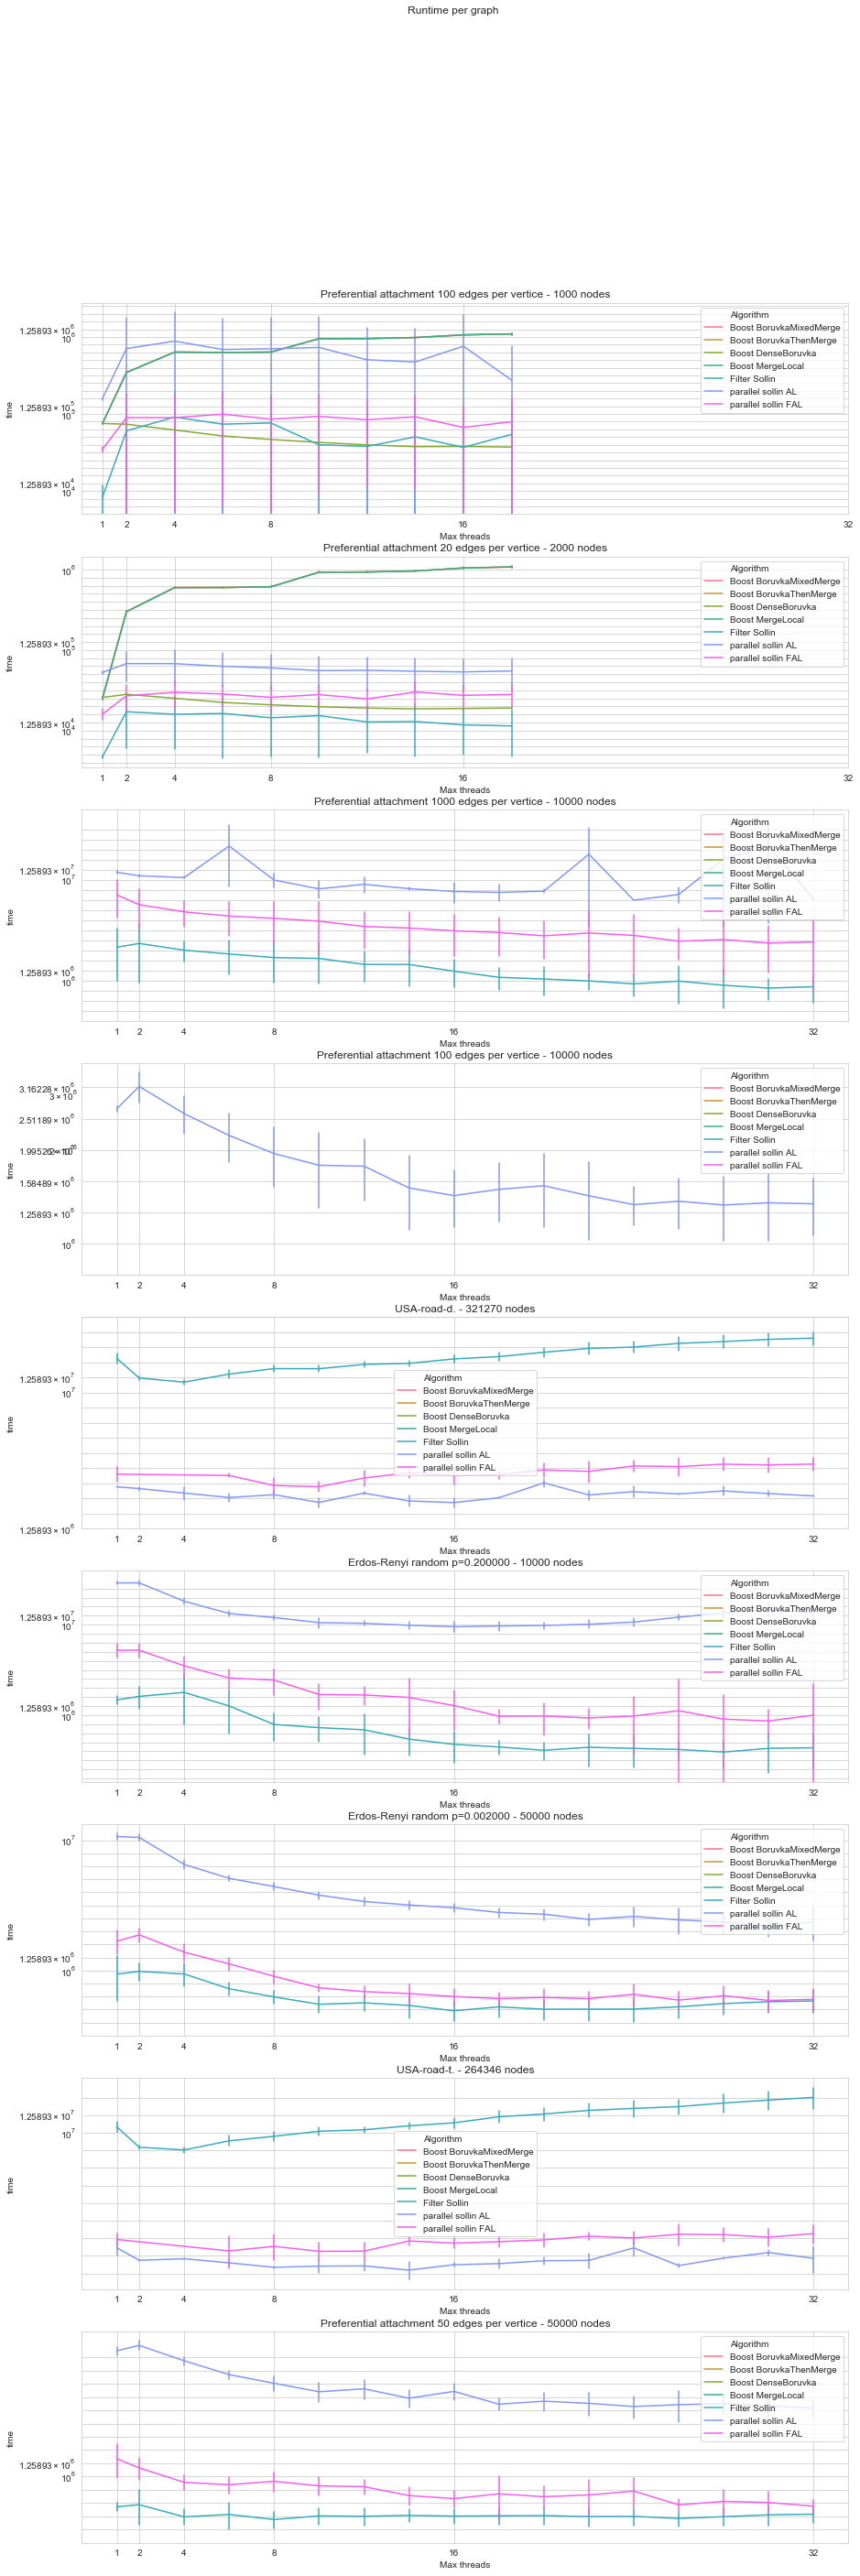

In [10]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/Graph_runtime.png", dpi=450)
plt.show()

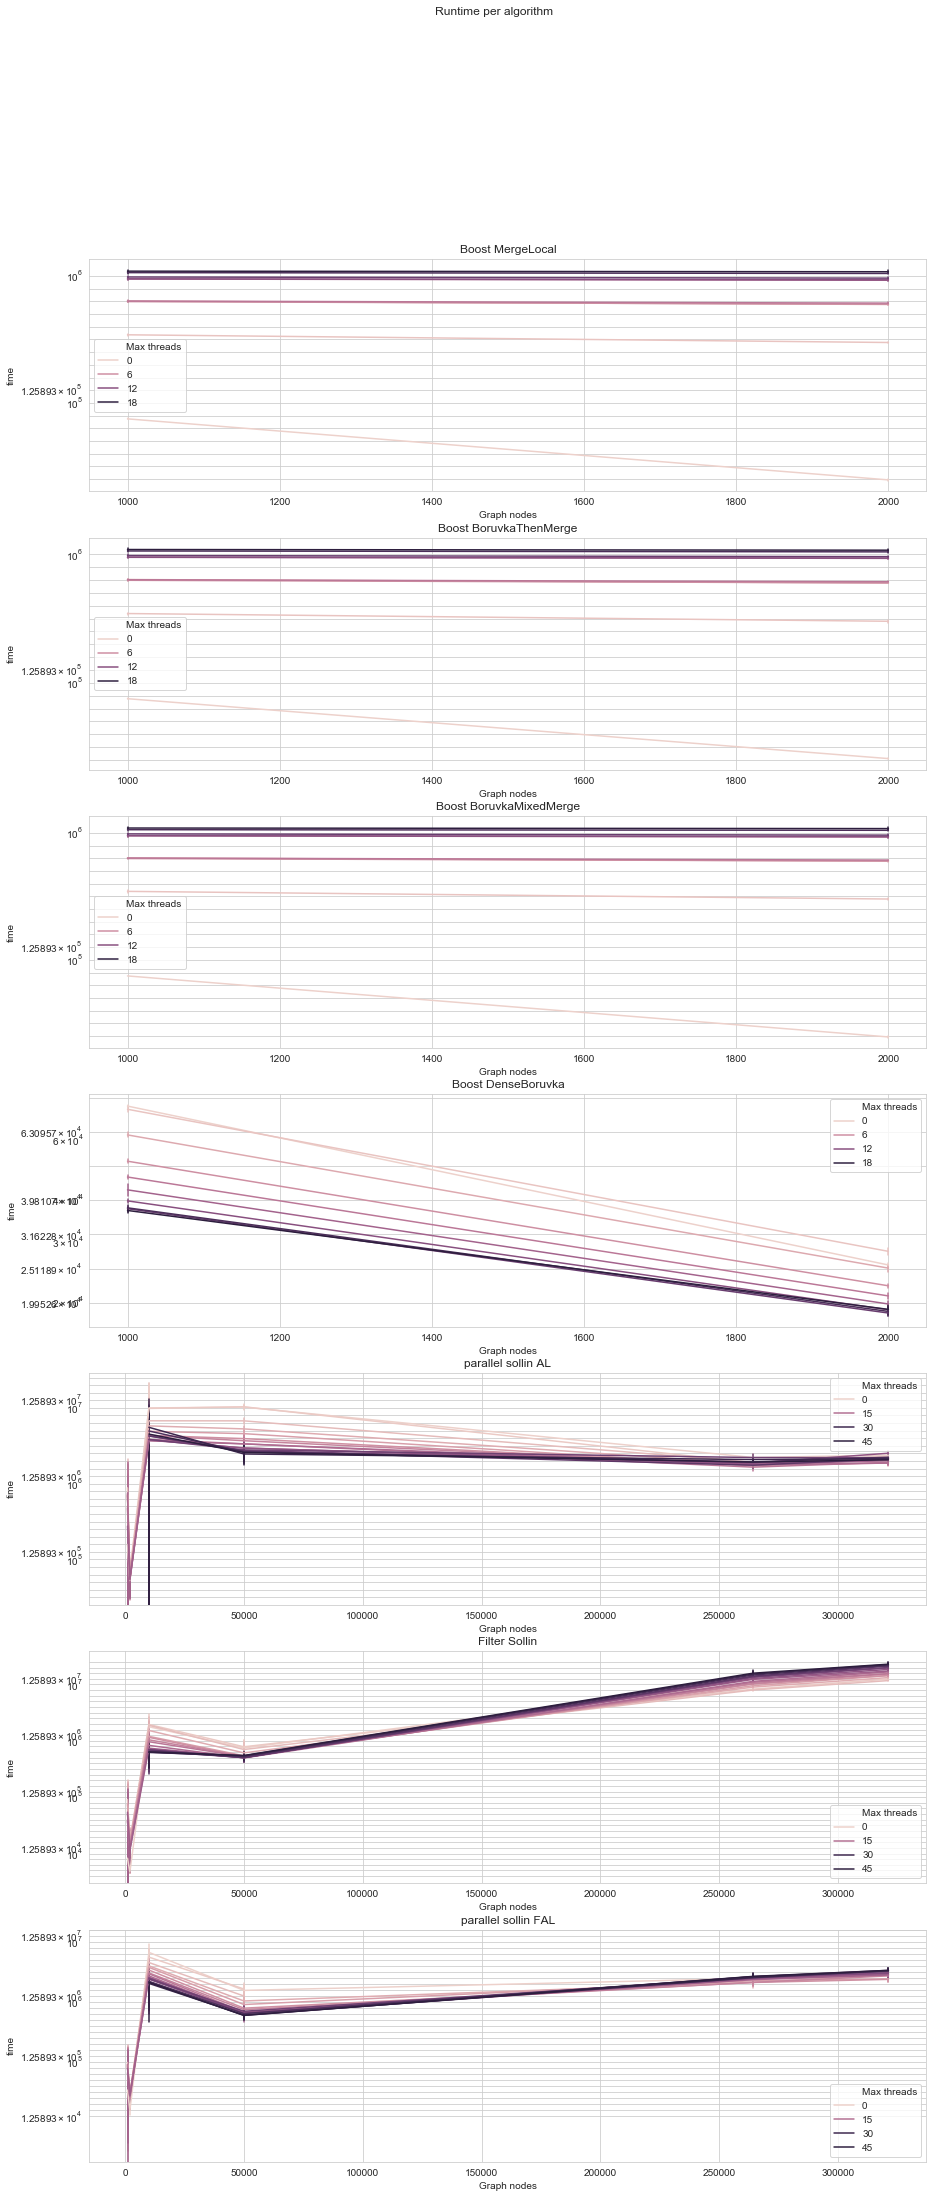

In [11]:
fig, ax = plt.subplots(nrows=len(df["Algorithm"].unique()),figsize=(15,5*len(df["Algorithm"].unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi,
        data=df[df["Algorithm"].values == e], 
        x="Graph nodes", 
        y="time", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df["Algorithm"].values == e]["time"]), np.max(df[df["Algorithm"].values == e]["time"])])
    axi.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    axi.set_title(f"{e}")
plt.suptitle("Runtime per algorithm")
fig.savefig(f"figures/{dataset}/AlgoRuntime.png", dpi=450)
plt.show()

In [12]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


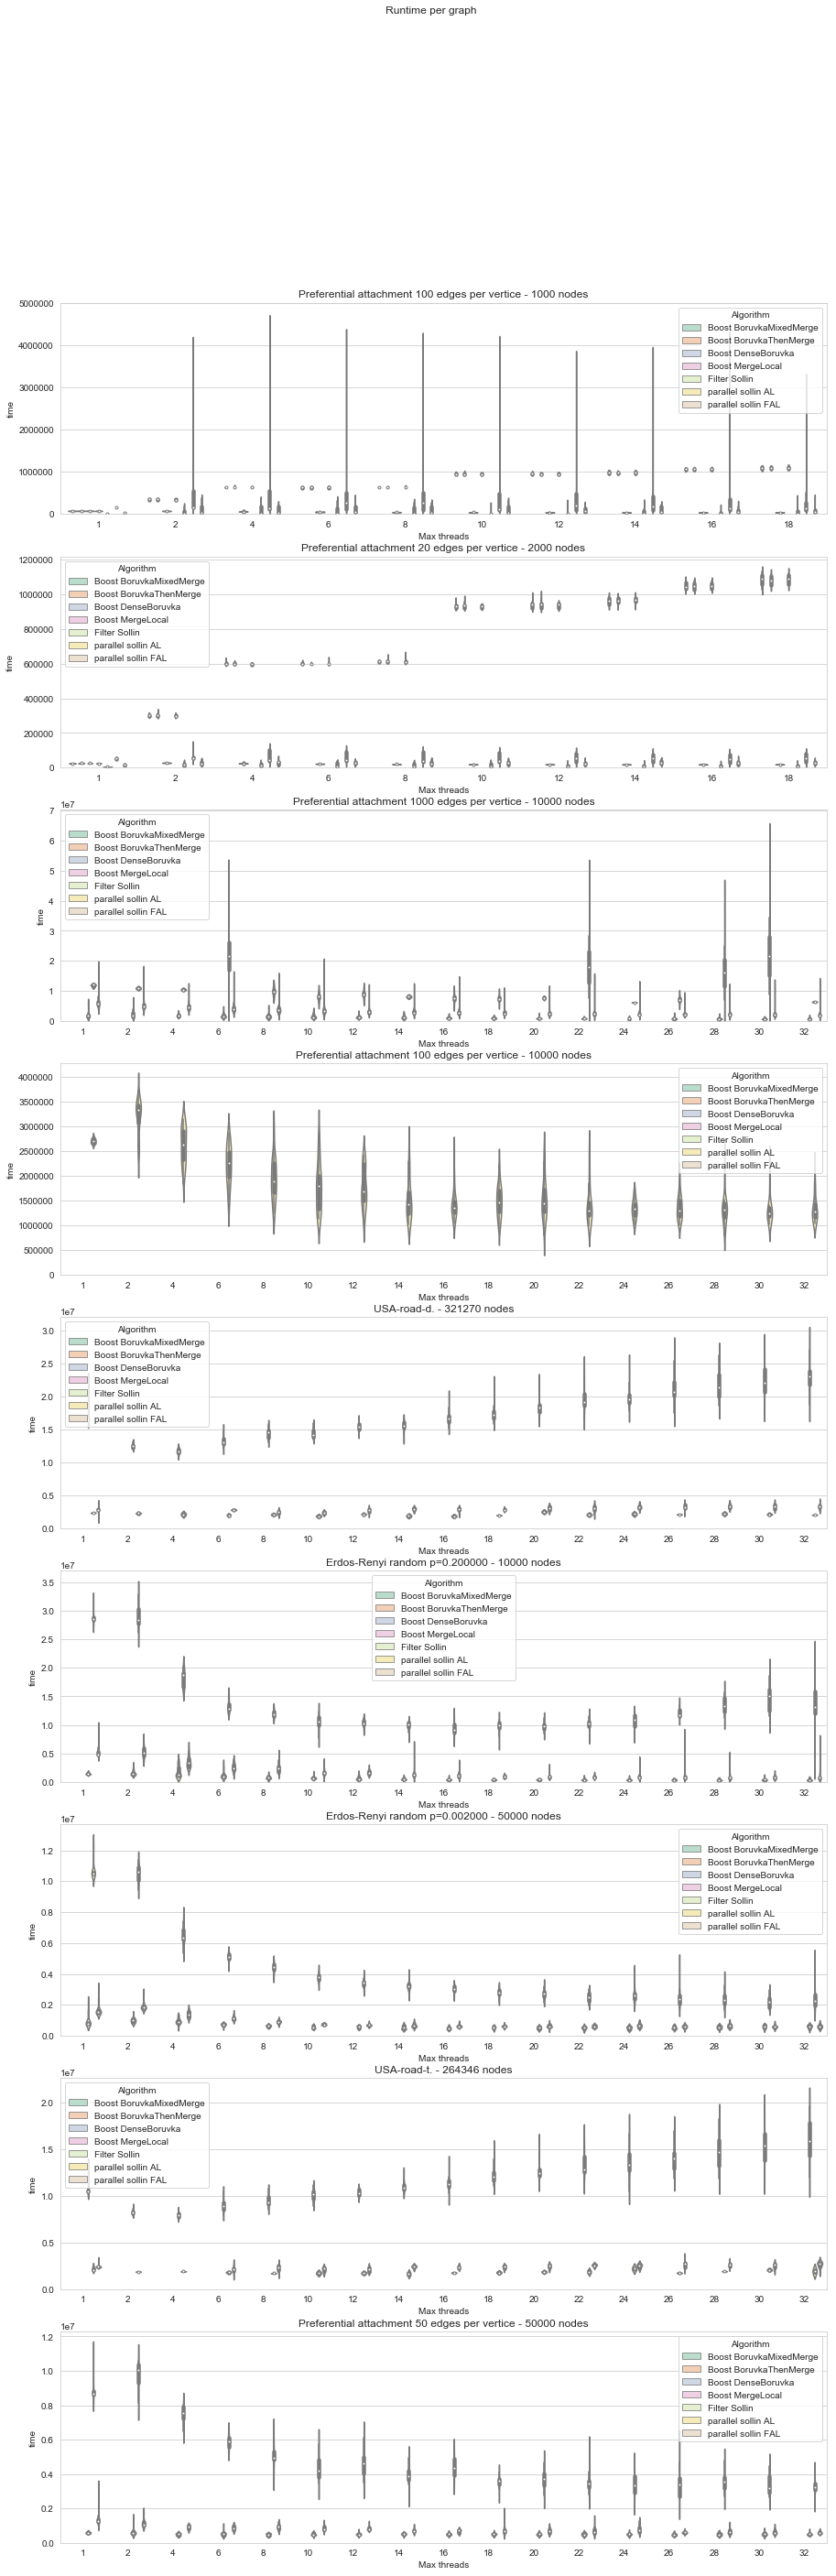

In [13]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/ViolinRuntime.png", dpi=450)
plt.show()

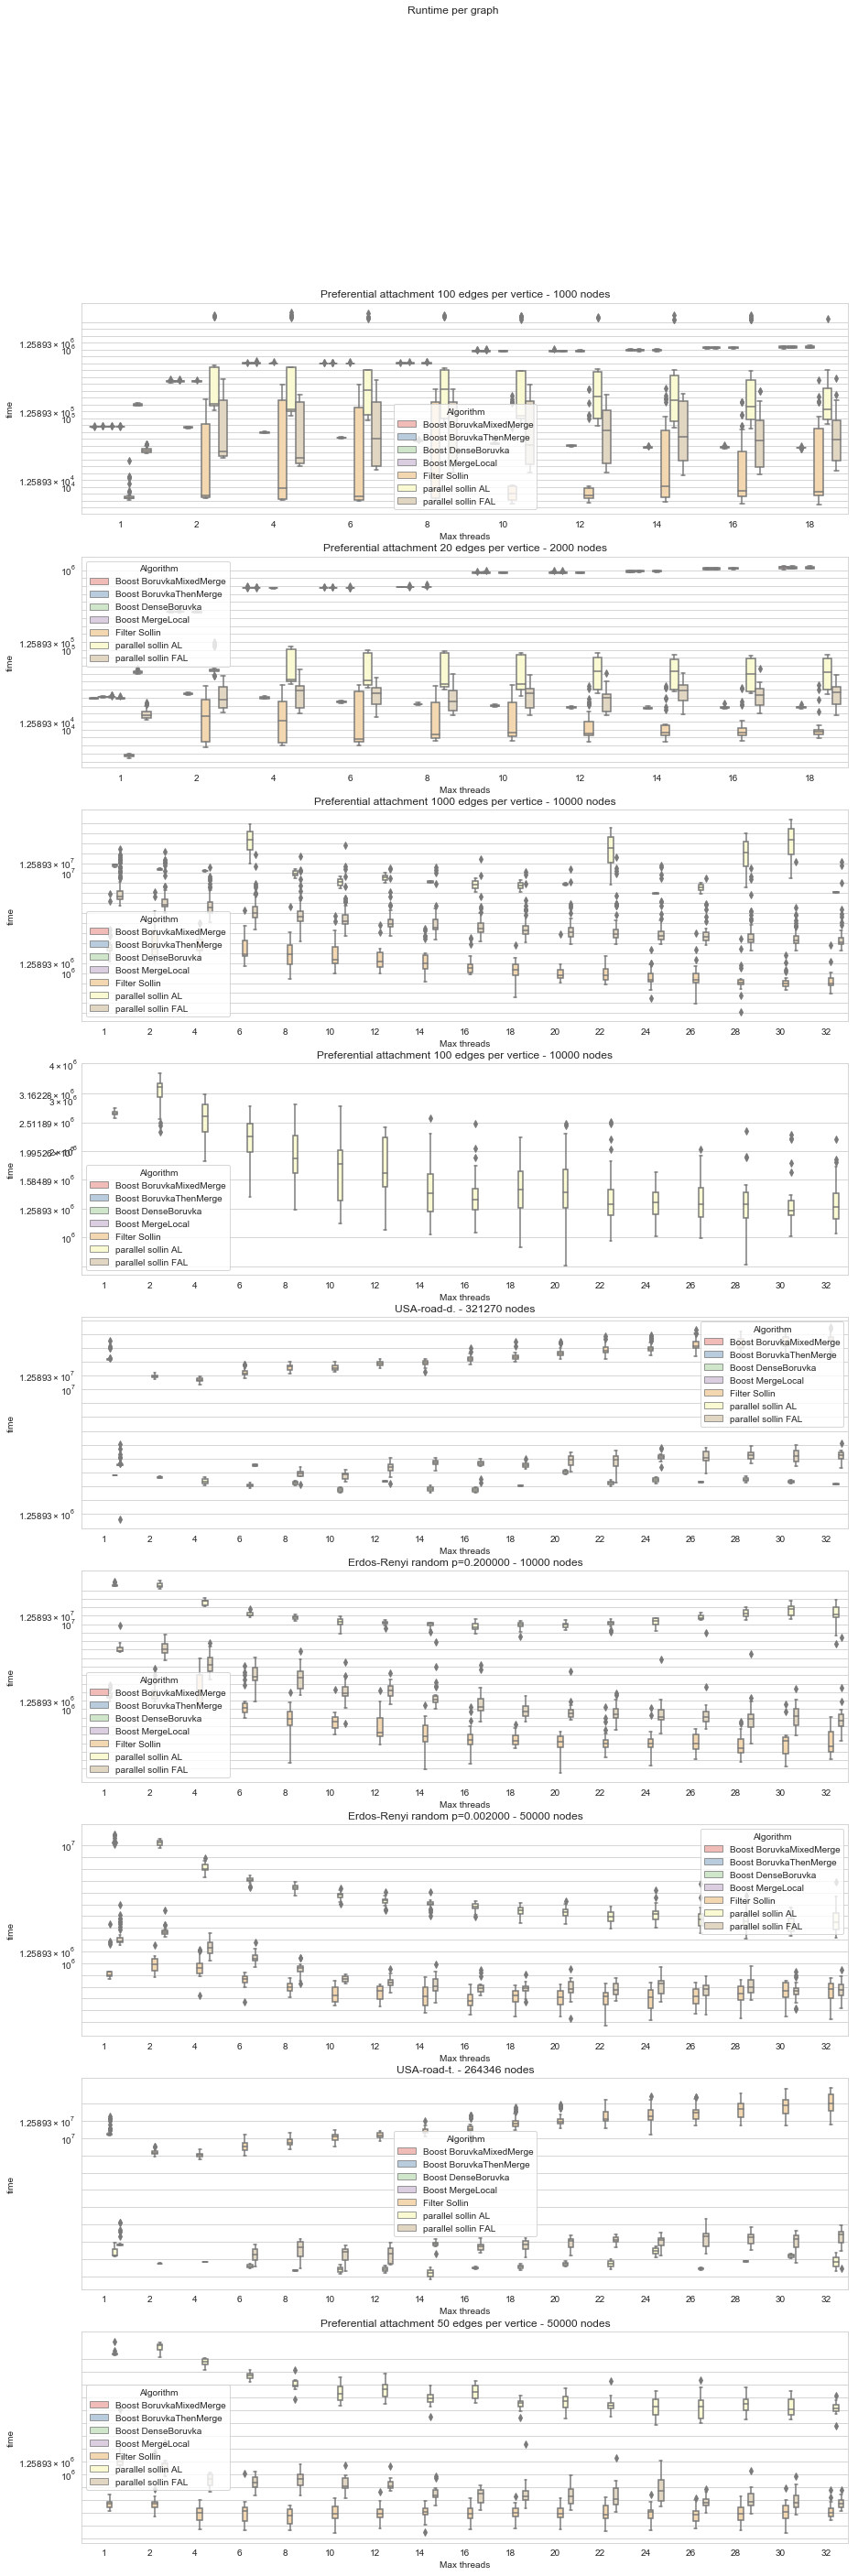

In [14]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/BoxRuntime.png", dpi=450)
plt.show()

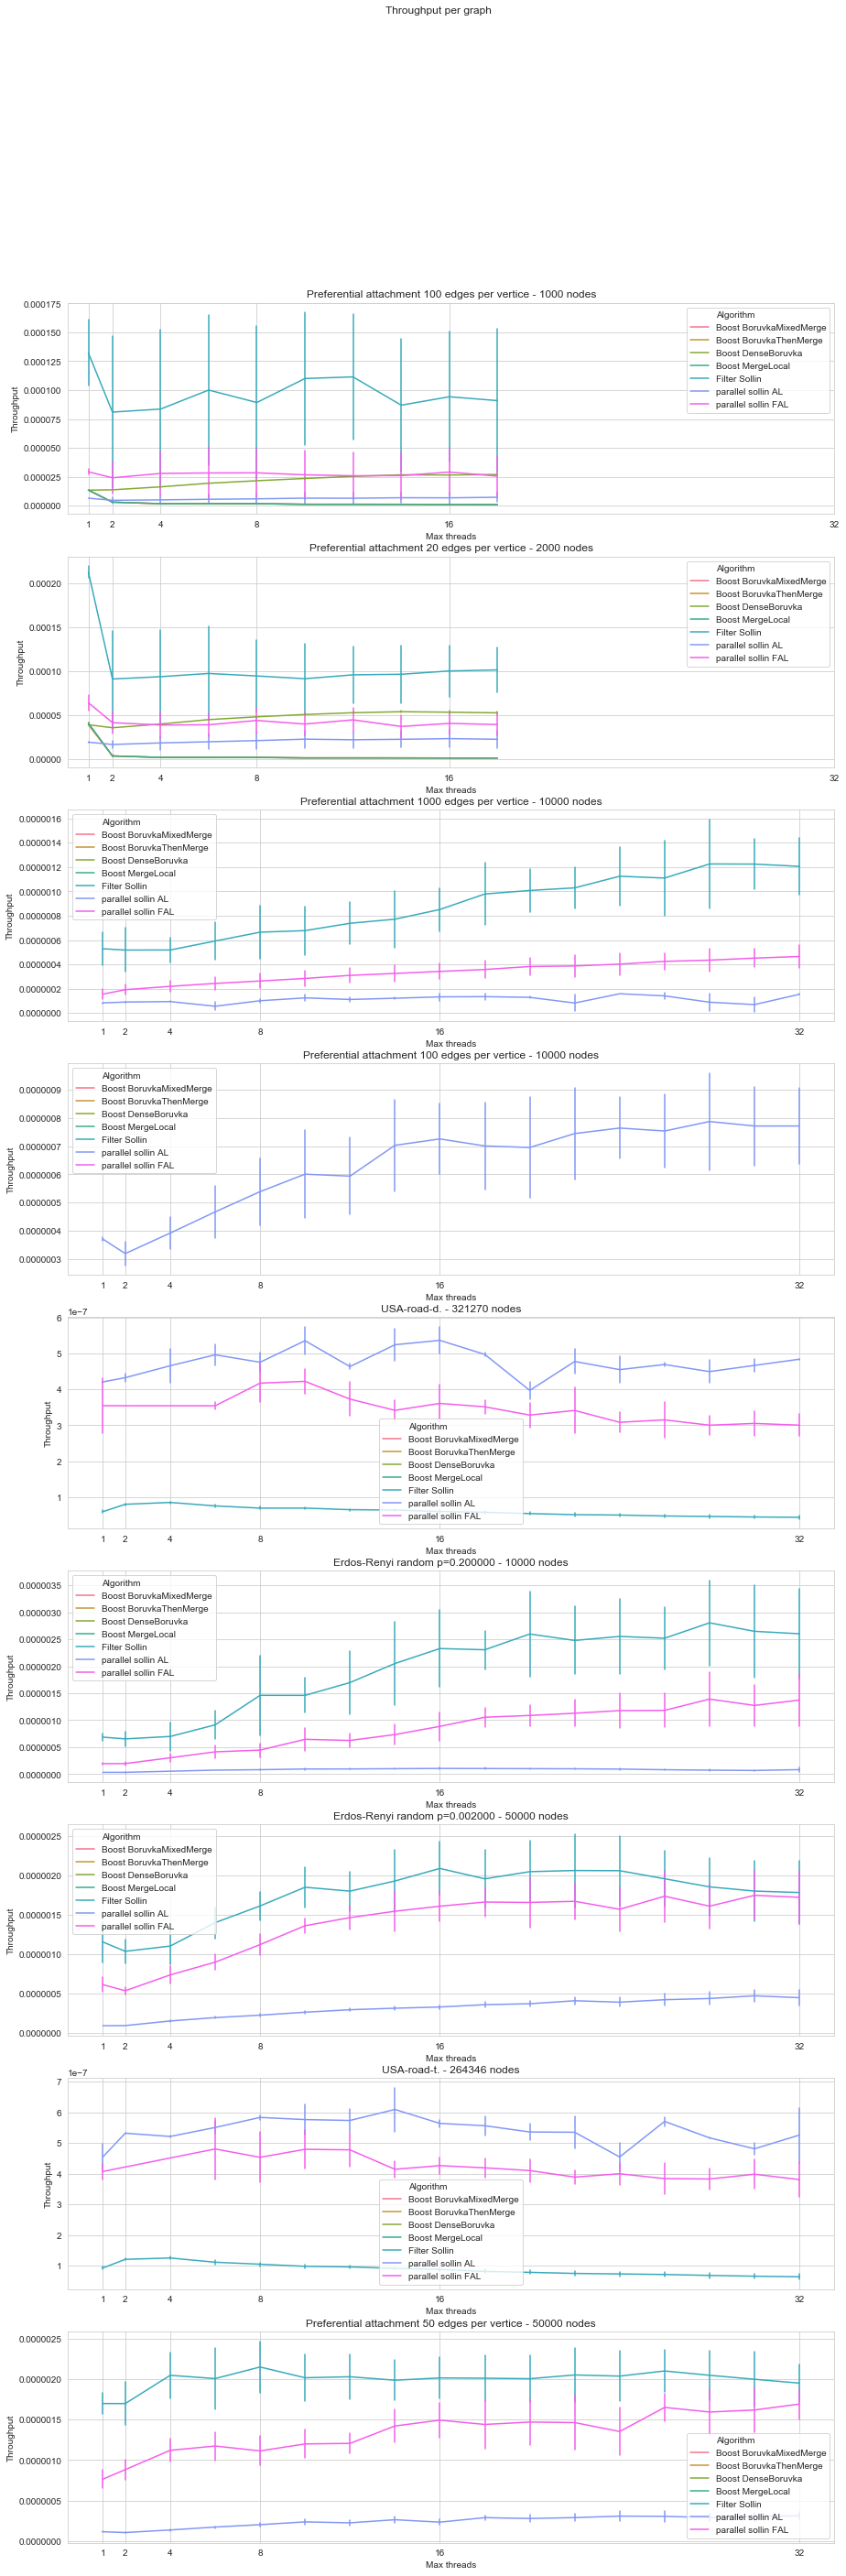

In [15]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Throughput", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Throughput per graph")
fig.savefig(f"figures/{dataset}/Throughput.png", dpi=450)
plt.show()

``` python
fig, ax = plt.subplots(nrows=len(df.Algorithm.unique()),figsize=(15,5*len(df.Algorithm.unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi, 
        data=df[df.Algorithm == e], 
        x="Graph nodes", 
        y="Reference speedup", 
        hue="Max threads",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    axi.set_title(f"{e}")
    axi.set_ylim(0,)
plt.suptitle(f"Speedup per graph against {reference_algorithm}")
r_name = reference_algorithm.replace(' ', '_')
fig.savefig(f"figures/{dataset}/Speedup_against_{r_name}.png", dpi=450)
plt.show()
```

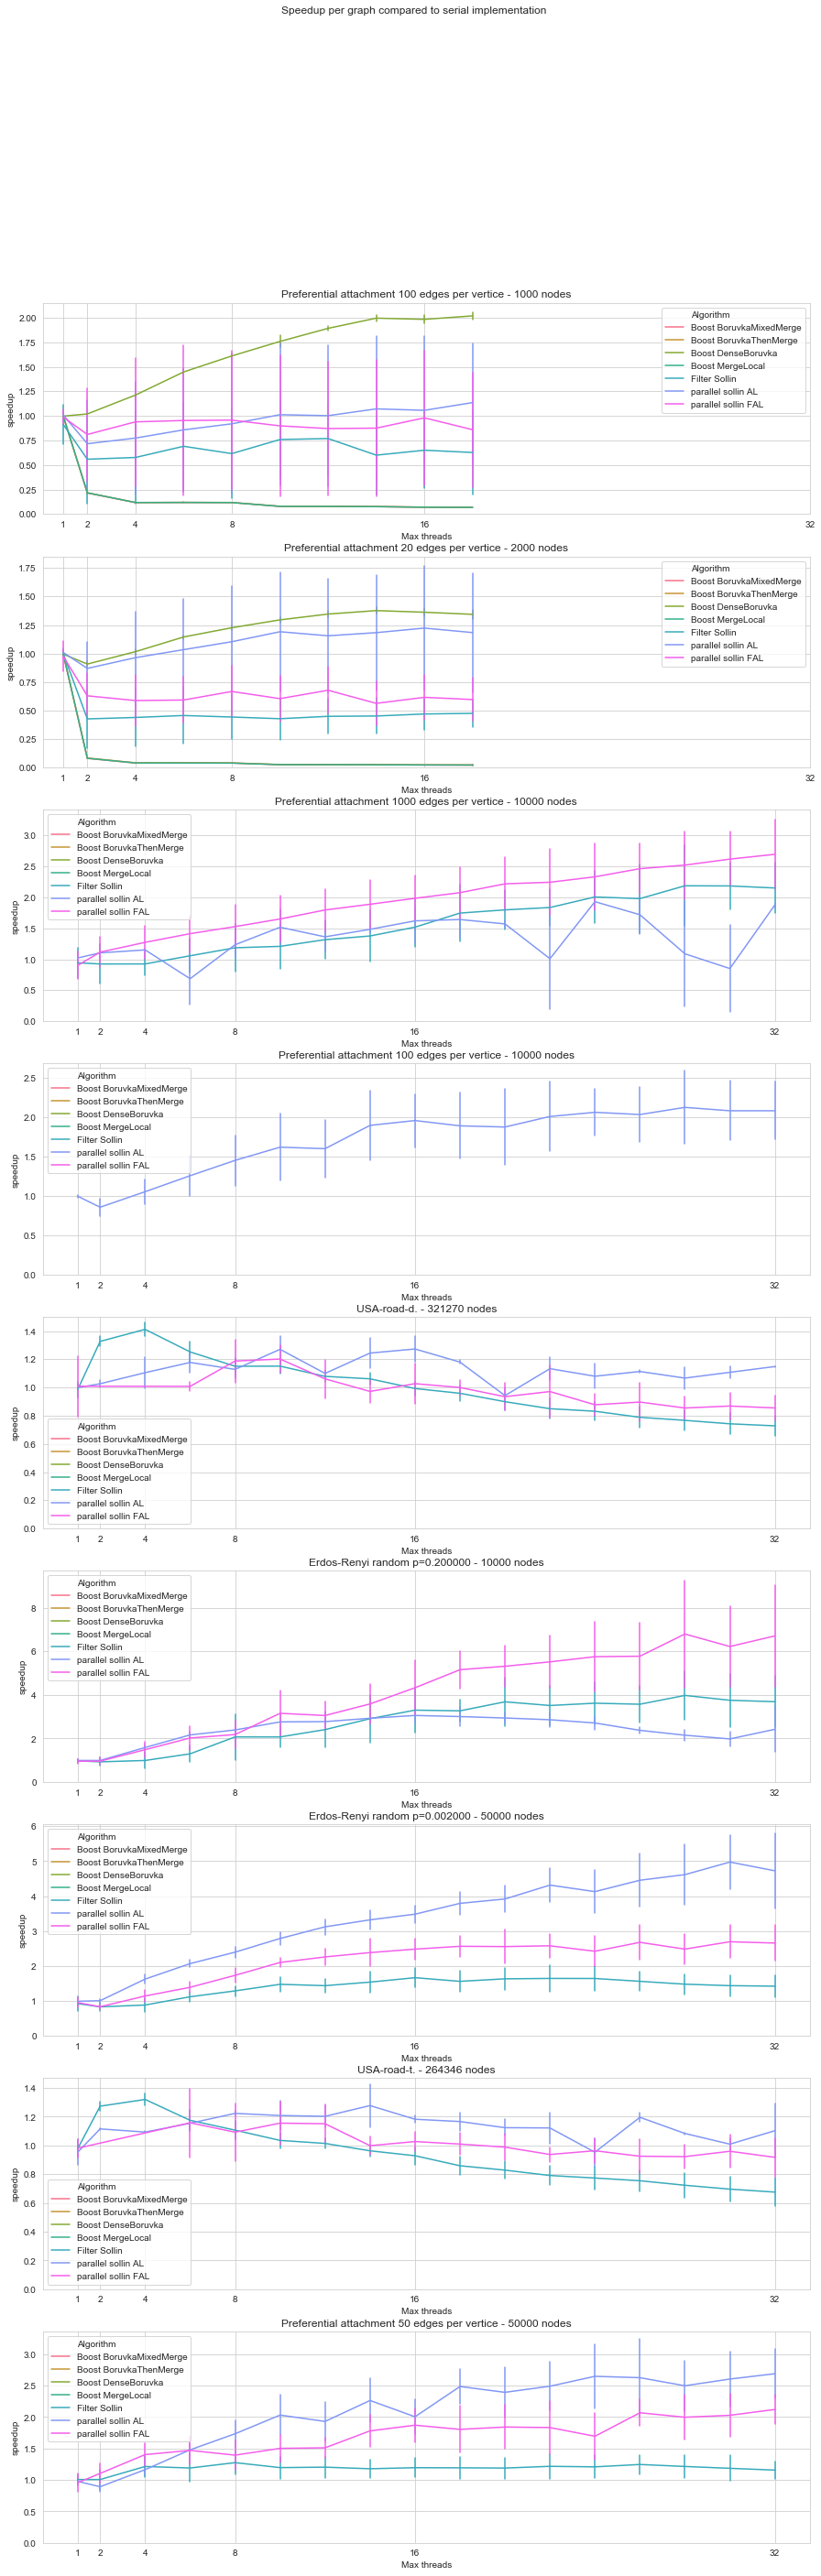

In [16]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_xticks(2**np.arange(0, 6, 1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle(f"Speedup per graph compared to serial implementation")
fig.savefig(f"figures/{dataset}/Speedup.png", dpi=450)
plt.show()

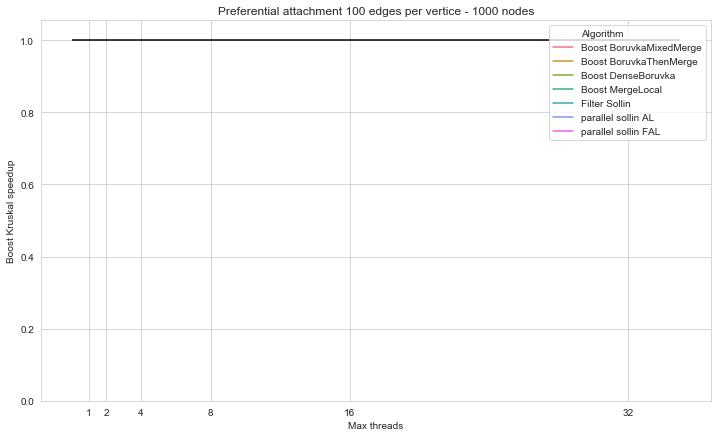

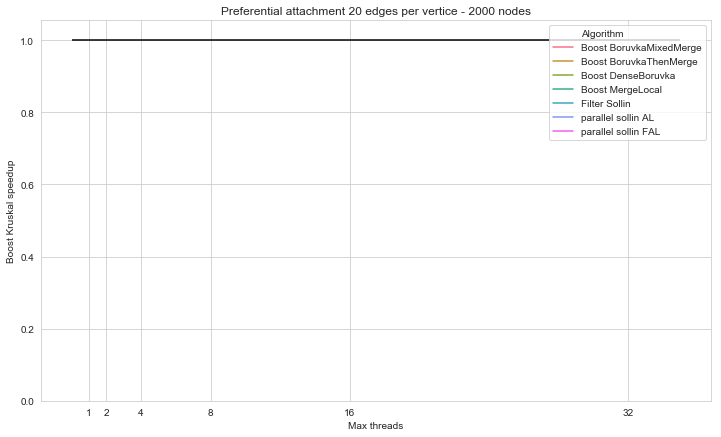

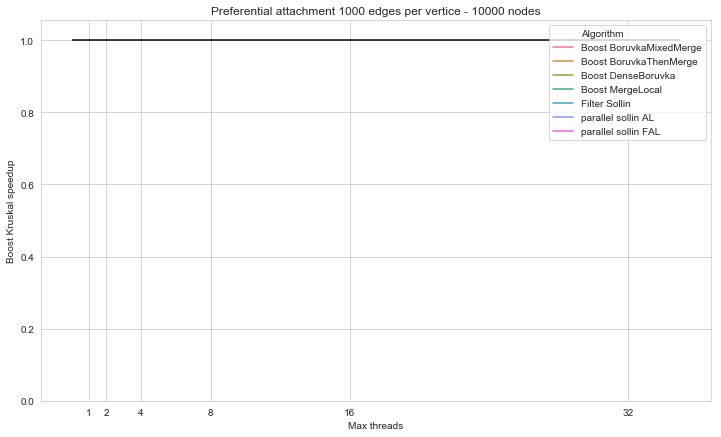

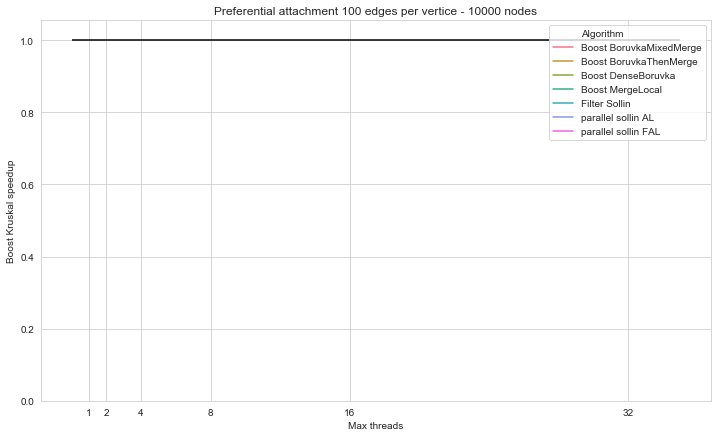

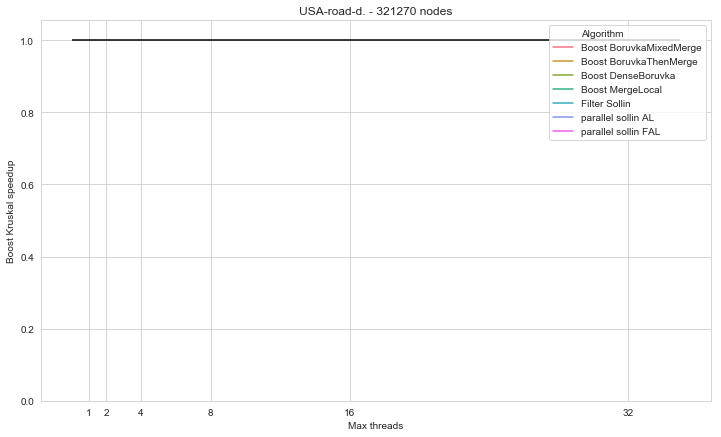

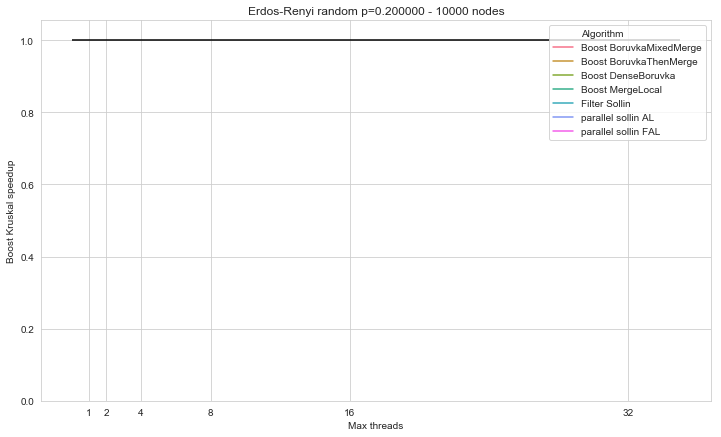

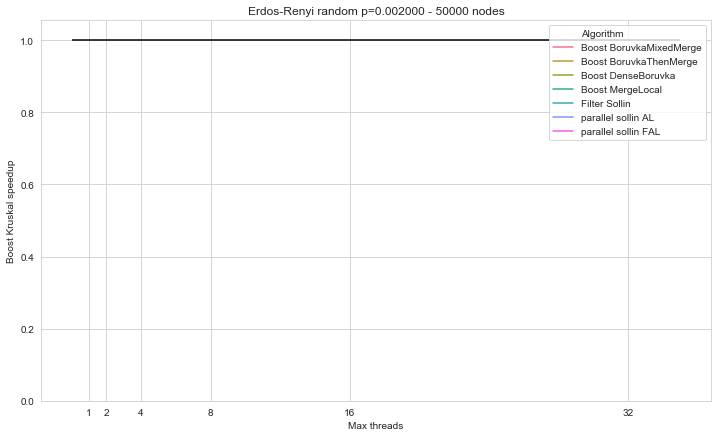

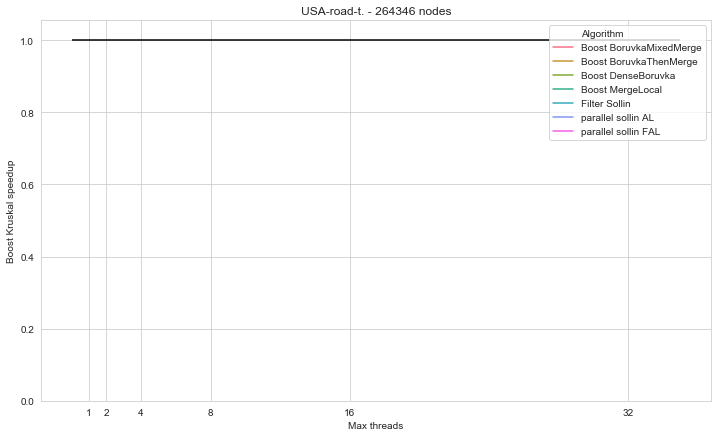

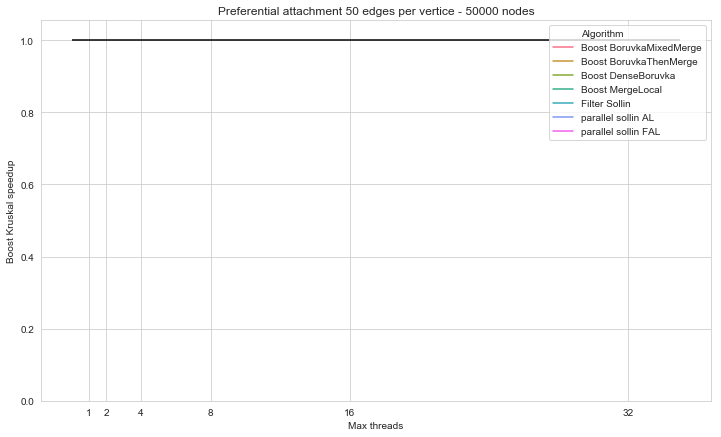

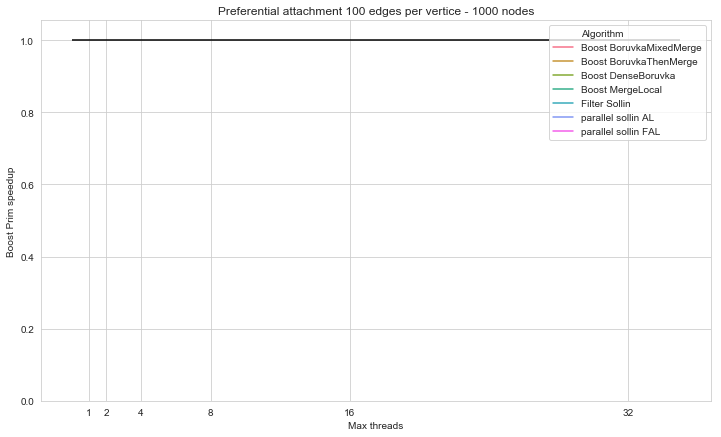

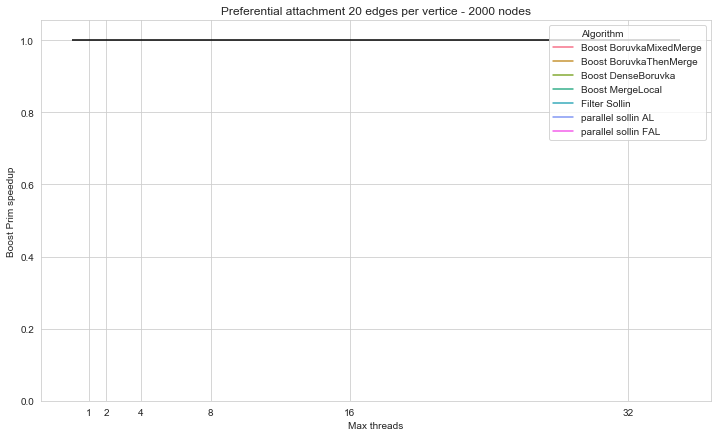

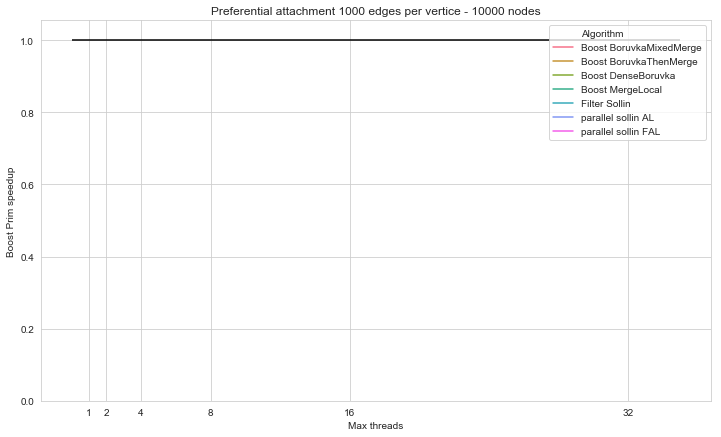

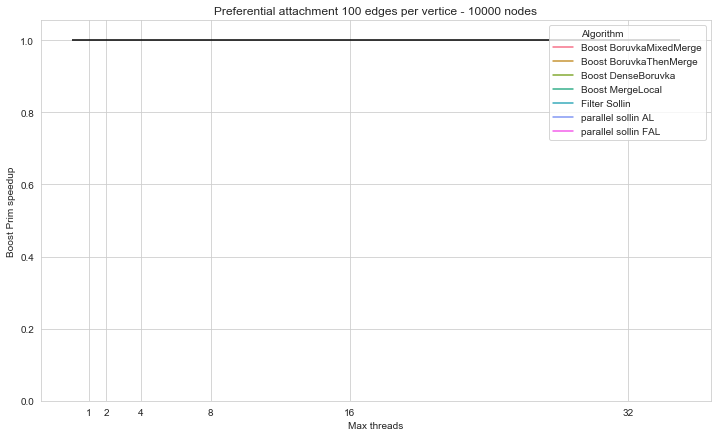

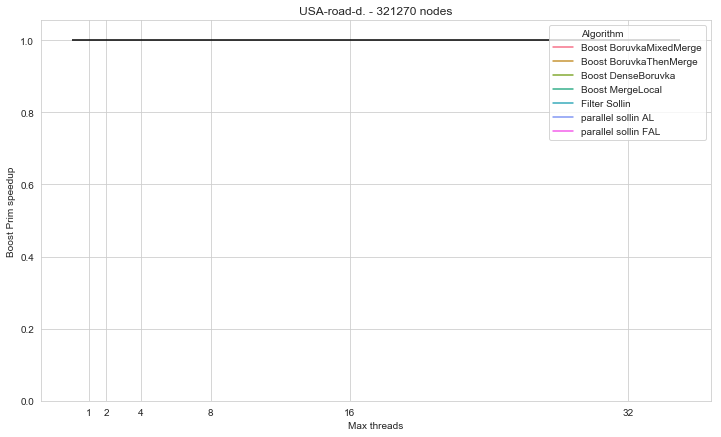

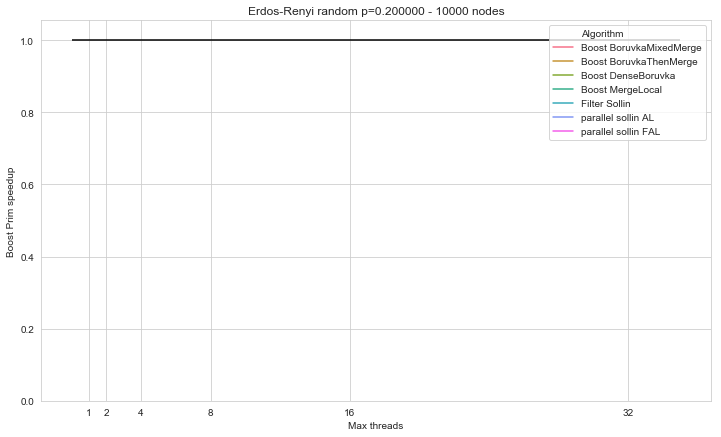

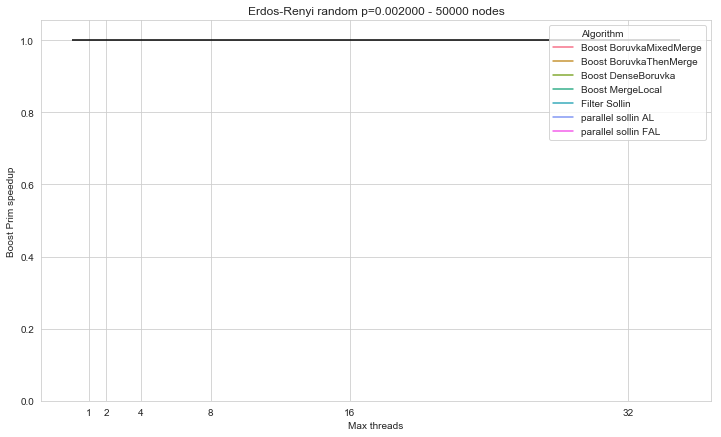

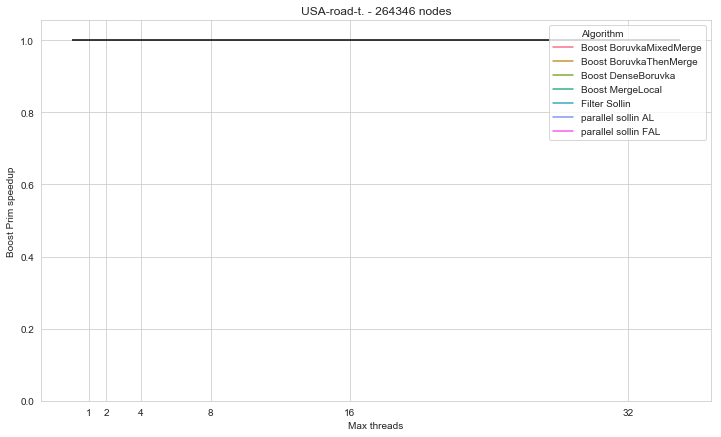

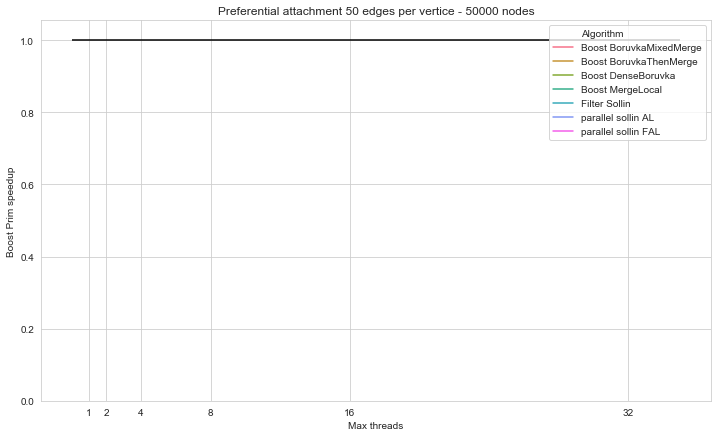

In [17]:
for ref_alg in references_algorithms:
    for i, e in enumerate(df.Graph.unique()):
        fig, ax = plt.subplots(figsize=(12, 7))
        #e = ('Preferential attachment 50 edges per vertice', 100000)
        sns.lineplot(
            ax=ax, 
            data=df[df.Graph == e], 
            x="Max threads", 
            y=f"{ref_alg} speedup", 
            hue="Algorithm",
            ci="sd",
            err_style="bars",
        )#.set(yscale="log")
        plt.hlines(y=1, xmin=0, xmax=35)
        ax.set_xticks(2**np.arange(0, 6, 1))
        ax.set_title(f"{e[0]} - {e[1]} nodes")
        ax.set_ylim(0,)
        fig.savefig(f"../presentations/final/graphics/{ref_alg.replace(' ', '')}Speedup{i}.png", dpi=450)
        plt.show()